1. Data Preproccesing

In [1]:
!pip install optuna
!pip install catboost
!pip install imblearn

import os
import time
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna

from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.0/616.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 15.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.8 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Diabetes Dataset/diabetes_dataset.csv'
save_dir = '/content/drive/My Drive/Diabetes Dataset/optuna_studies'


# Load the dataset
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print("Initial few rows of the dataset:")
print(df.head())

# 1. Data Preprocessing

# 1.1 Combine race columns into a single numerical column using binary encoding
race_columns = ['race:AfricanAmerican', 'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other']
df['race'] = df[race_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df.drop(columns=race_columns, inplace=True)

# 1.2 Handling Missing Values
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)
""""
# Impute missing values with the mean for numerical columns and the most frequent value for categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
"""
# 1.3 Encoding Categorical Variables
# Binary encoding for gender and location
binary_encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
binary_encoded = binary_encoder.fit_transform(df[['gender', 'location']])
binary_encoded_df = pd.DataFrame(binary_encoded, columns=binary_encoder.get_feature_names_out(['gender', 'location']))
df = pd.concat([df, binary_encoded_df], axis=1)
df.drop(columns=['gender', 'location'], inplace=True)

# Decide on encoding for smoking_history
# Since smoking_history has multiple categories, we will use label encoding
label_encoder = LabelEncoder()
df['smoking_history'] = label_encoder.fit_transform(df['smoking_history'])

# Encode the race column using label encoding
df['race'] = label_encoder.fit_transform(df['race'])

# 1.4 Standardization
# Standardize numerical features
scaler = StandardScaler()
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
df[num_features] = scaler.fit_transform(df[num_features])

# Split the features from the label
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# Display the preprocessed features and label
print("Features (X):\n", X.head())
print("\nLabel (y):\n", y.head())




#--------------------------------------------------------------------#


# Assuming X and y are already defined from the previous preprocessing steps

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the class distribution before and after applying SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())



#--------------------------------------------------------------#


"""
# Manually select the features
selected_features = ['year', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'hbA1c_level', 'blood_glucose_level', 'race', 'gender_Female',
       'gender_Male', 'location_Alabama', 'location_Alaska',
       'location_Arizona', 'location_Arkansas', 'location_California',
       'location_Colorado', 'location_Connecticut', 'location_Delaware',
       'location_District of Columbia', 'location_Florida', 'location_Georgia',
       'location_Guam', 'location_Hawaii', 'location_Idaho',
       'location_Illinois', 'location_Indiana', 'location_Iowa',
       'location_Kansas', 'location_Kentucky', 'location_Louisiana',
       'location_Maine', 'location_Maryland', 'location_Massachusetts',
       'location_Michigan', 'location_Minnesota', 'location_Mississippi',
       'location_Missouri', 'location_Montana', 'location_Nebraska',
       'location_Nevada', 'location_New Hampshire', 'location_New Jersey',
       'location_New Mexico', 'location_New York', 'location_North Carolina',
       'location_North Dakota', 'location_Ohio', 'location_Oklahoma',
       'location_Oregon', 'location_Pennsylvania', 'location_Puerto Rico',
       'location_Rhode Island', 'location_South Carolina',
       'location_South Dakota', 'location_Tennessee', 'location_Texas',
       'location_United States', 'location_Utah', 'location_Vermont',
       'location_Virginia', 'location_Washington', 'location_West Virginia']

# Transform the training and testing sets to include only the selected features
X_train_rfecv = X_train_smote[selected_features]
X_test_rfecv = X_test[selected_features]

"""
#--------------------------------------------------------------------#


# Define a dictionary to store the performance metrics and training time
model_performance = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Training Time': [],
    'Best Parameters': []
}

# Function to evaluate and store model performance
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, param_grid):
    start_time = time.time()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    training_time = time.time() - start_time

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_performance['Model'].append(model_name)
    model_performance['Accuracy'].append(accuracy)
    model_performance['F1 Score'].append(f1)
    model_performance['Training Time'].append(training_time)
    model_performance['Best Parameters'].append(grid_search.best_params_)

    return grid_search.best_params_


Mounted at /content/drive
Initial few rows of the dataset:
   year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020  Female  32.0  Alabama                     0           0   
1  2015  Female  29.0  Alabama                     0           1   
2  2015    Male  18.0  Alabama                     0           0   
3  2015    Male  41.0  Alabama                     0           0   
4  2016  Female  52.0  Alabama                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

  smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes 

2. GIVE ME SOME JUICY GRAPHS 🤤

Summary Statistics:
                 year            age  race:AfricanAmerican     race:Asian  \
count  100000.000000  100000.000000         100000.000000  100000.000000   
mean     2018.360820      41.885856              0.202230       0.200150   
std         1.345239      22.516840              0.401665       0.400114   
min      2015.000000       0.080000              0.000000       0.000000   
25%      2019.000000      24.000000              0.000000       0.000000   
50%      2019.000000      43.000000              0.000000       0.000000   
75%      2019.000000      60.000000              0.000000       0.000000   
max      2022.000000      80.000000              1.000000       1.000000   

       race:Caucasian  race:Hispanic     race:Other  hypertension  \
count   100000.000000   100000.00000  100000.000000  100000.00000   
mean         0.198760        0.19888       0.199980       0.07485   
std          0.399069        0.39916       0.399987       0.26315   
min          0.000

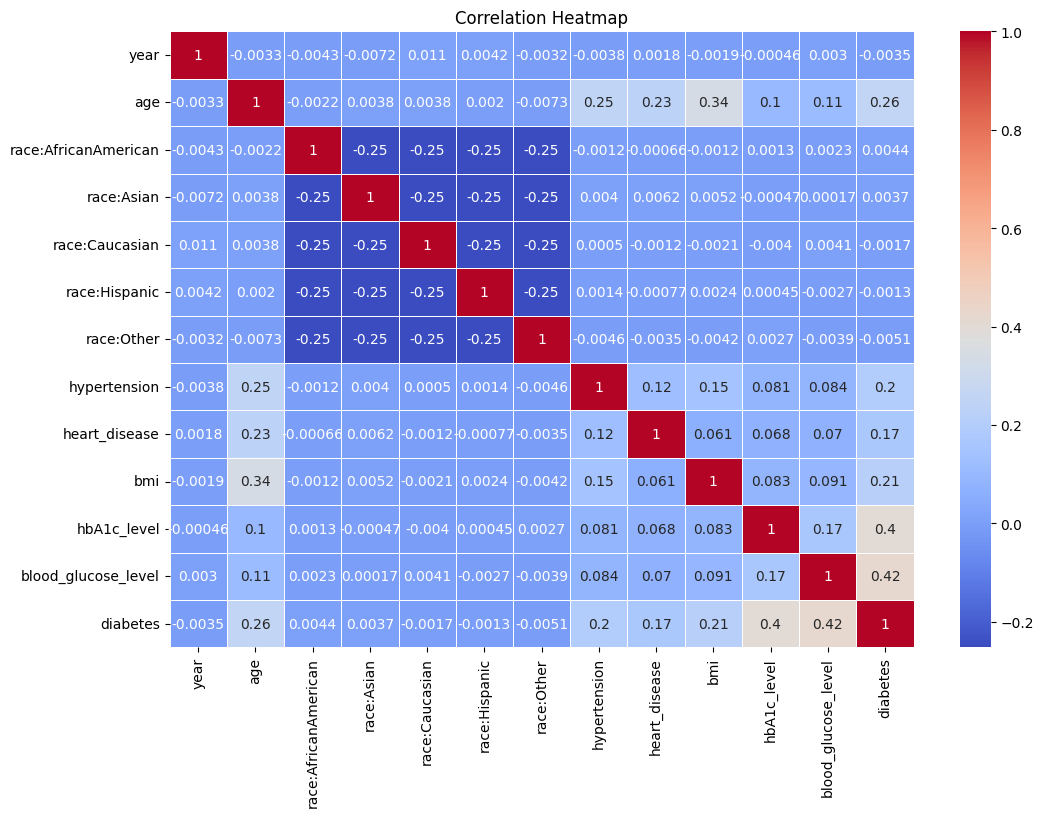

Class distribution in the target variable (diabetes):
 diabetes
0    91500
1     8500
Name: count, dtype: int64


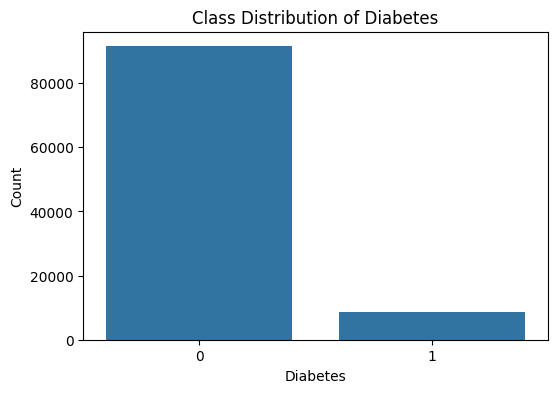

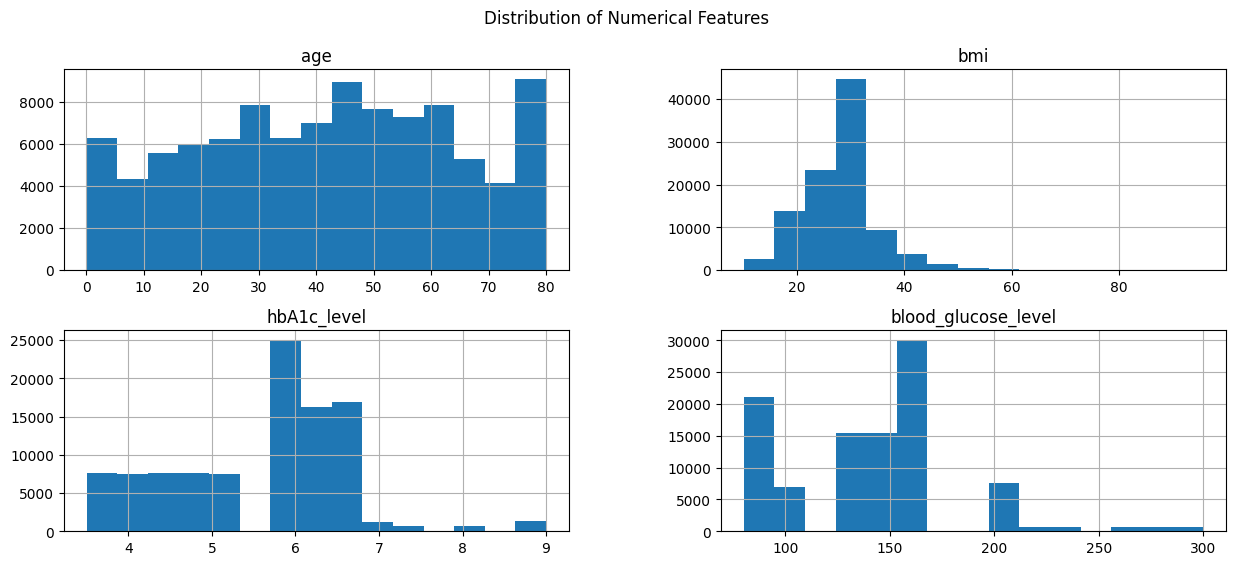

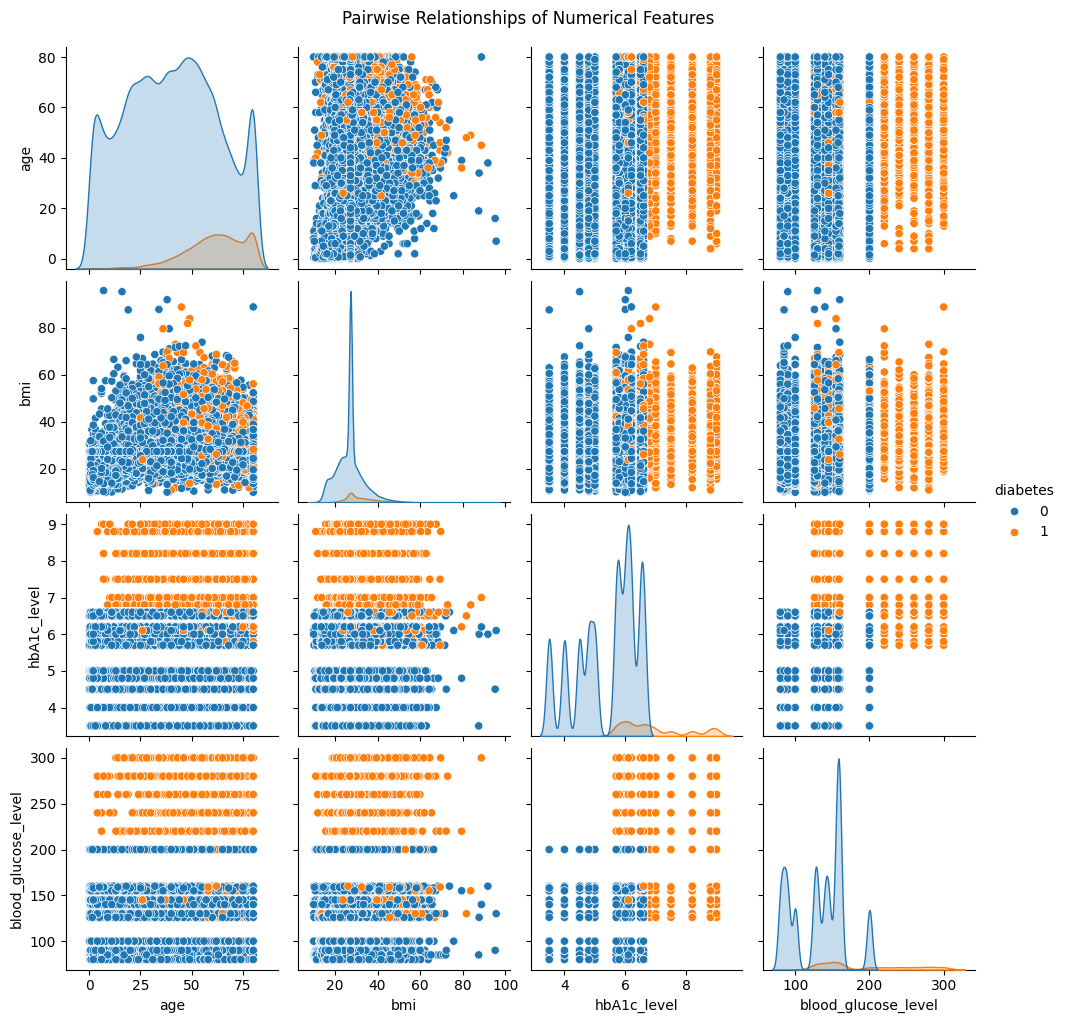

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Exploratory Data Analysis (EDA)

# Reload the original dataset for EDA
df_original = pd.read_csv('diabetes_dataset.csv')

# 2.1 Descriptive Statistics: Calculate summary statistics for numerical features
summary_stats = df_original.describe()
print("Summary Statistics:\n", summary_stats)

# 2.2 Data Visualization

# 2.2.1 Heatmap of features correlation
plt.figure(figsize=(12, 8))
# Select only numeric columns for correlation matrix
numeric_cols = df_original.select_dtypes(include=[np.number]).columns
correlation_matrix = df_original[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 2.3 Class Imbalance: Check for class imbalance in the target variable (diabetes)
class_counts = df_original['diabetes'].value_counts()
print("Class distribution in the target variable (diabetes):\n", class_counts)

# Plot the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes', data=df_original)
plt.title('Class Distribution of Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

# Additional Visualizations (if necessary)

# Distribution of numerical features
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
df_original[num_features].hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Pairplot to see pairwise relationships
sns.pairplot(df_original, hue='diabetes', vars=num_features)
plt.suptitle('Pairwise Relationships of Numerical Features', y=1.02)
plt.show()

2.1 WARNING FOUND IMBALANACE HELP

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined from the previous preprocessing steps

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, , stratify=y)

# Apply SMOTE to the training data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the class distribution before and after applying SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution before SMOTE:
diabetes
0    73200
1     6800
Name: count, dtype: int64

Class distribution after SMOTE:
diabetes
0    73200
1    73200
Name: count, dtype: int64


2.2??? Apply RFE for MAX POWER

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize RFECV with the Random Forest classifier
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV
rfecv.fit(X_train_smote, y_train_smote)

# Get the selected features
selected_features = X_train_smote.columns[rfecv.support_]

# Transform the training and testing sets to include only the selected features
X_train_rfecv = rfecv.transform(X_train_smote)
X_test_rfecv = rfecv.transform(X_test)

# Display the selected features and the optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected features:\n", selected_features)



KeyboardInterrupt: 

In [ ]:
from imblearn.over_sampling import SMOTE

# Manually select the features
selected_features = ['year', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'hbA1c_level', 'blood_glucose_level', 'race', 'gender_Female',
       'gender_Male', 'location_Alabama', 'location_Alaska',
       'location_Arizona', 'location_Arkansas', 'location_California',
       'location_Colorado', 'location_Connecticut', 'location_Delaware',
       'location_District of Columbia', 'location_Florida', 'location_Georgia',
       'location_Guam', 'location_Hawaii', 'location_Idaho',
       'location_Illinois', 'location_Indiana', 'location_Iowa',
       'location_Kansas', 'location_Kentucky', 'location_Louisiana',
       'location_Maine', 'location_Maryland', 'location_Massachusetts',
       'location_Michigan', 'location_Minnesota', 'location_Mississippi',
       'location_Missouri', 'location_Montana', 'location_Nebraska',
       'location_Nevada', 'location_New Hampshire', 'location_New Jersey',
       'location_New Mexico', 'location_New York', 'location_North Carolina',
       'location_North Dakota', 'location_Ohio', 'location_Oklahoma',
       'location_Oregon', 'location_Pennsylvania', 'location_Puerto Rico',
       'location_Rhode Island', 'location_South Carolina',
       'location_South Dakota', 'location_Tennessee', 'location_Texas',
       'location_United States', 'location_Utah', 'location_Vermont',
       'location_Virginia', 'location_Washington', 'location_West Virginia']

# Transform the training and testing sets to include only the selected features
X_train_rfecv = X_train_smote[selected_features]
X_test_rfecv = X_test[selected_features]

4. MODEL SHOWDOWN

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import time
import pandas as pd

# Define a dictionary to store the performance metrics and training time
model_performance = {
    'Model': [],
    'Accuracy': [],
    'F1 Score': [],
    'Training Time': [],
    'Best Parameters': []
}

# Function to evaluate and store model performance
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, param_grid):
    start_time = time.time()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    training_time = time.time() - start_time

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    model_performance['Model'].append(model_name)
    model_performance['Accuracy'].append(accuracy)
    model_performance['F1 Score'].append(f1)
    model_performance['Training Time'].append(training_time)
    model_performance['Best Parameters'].append(grid_search.best_params_)

    return grid_search.best_params_


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the LogisticRegression model
log_reg = LogisticRegression(max_iter=1000)

# Define the parameter grid
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=log_reg_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_log_reg = grid_search.best_estimator_

# Evaluate the model
y_pred = best_log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

# Optionally, print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     18300
           1       0.42      0.87      0.56      1700

    accuracy                           0.89     20000
   macro avg       0.70      0.88      0.75     20000
weighted avg       0.94      0.89      0.90     20000

Best parameters found:  {'C': 1, 'solver': 'saga'}
Best cross-validation score:  0.8857650273224044


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the RandomForestClassifier model
rf = RandomForestClassifier()

# Define the extended parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Evaluate the model
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Optionally, print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18300
           1       0.69      0.77      0.73      1700

    accuracy                           0.95     20000
   macro avg       0.84      0.87      0.85     20000
weighted avg       0.95      0.95      0.95     20000

Best parameters found:  {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score:  0.9724658469945355


In [ ]:
rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
evaluate_model('Random Forest', rf, X_train_smote, y_train_smote, X_test, y_test, rf_param_grid)

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the CatBoostClassifier
catboost = CatBoostClassifier(verbose=0)

# Define the parameter grid
catboost_param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=catboost, param_grid=catboost_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_catboost = grid_search.best_estimator_

# Evaluate the model
y_pred = best_catboost.predict(X_test)
print(classification_report(y_test, y_pred))

# Optionally, print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.98      0.67      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.97      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000

Best parameters found:  {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best cross-validation score:  0.9803551912568306


In [ ]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the SVC model
svm = SVC()

# Define the parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_svm = grid_search.best_estimator_

# Evaluate the model
y_pred = best_svm.predict(X_test)
print(classification_report(y_test, y_pred))

# Optionally, print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

SVC BAD

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Define the SVC model with default hyperparameters
svm = SVC()

# Fit the model
svm.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = svm.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     18300
           1       0.41      0.84      0.55      1700

    accuracy                           0.88     20000
   macro avg       0.70      0.86      0.74     20000
weighted avg       0.93      0.88      0.90     20000



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the KNeighborsClassifier model
knn = KNeighborsClassifier()

# Define the parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10, 20, 40],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_knn = grid_search.best_estimator_

# Evaluate the model
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred))

# Optionally, print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     18300
           1       0.52      0.67      0.58      1700

    accuracy                           0.92     20000
   macro avg       0.74      0.81      0.77     20000
weighted avg       0.93      0.92      0.92     20000

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score:  0.9618442622950821


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define the GaussianNB model
gnb = GaussianNB()

# Define the parameter grid
gnb_param_grid = {
    'var_smoothing': np.logspace(-9, -6, 4)
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gnb, param_grid=gnb_param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_gnb = grid_search.best_estimator_

# Evaluate the model
y_pred = best_gnb.predict(X_test)
print(classification_report(y_test, y_pred))

# Optionally, print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81     18300
           1       0.20      0.82      0.32      1700

    accuracy                           0.70     20000
   macro avg       0.59      0.75      0.56     20000
weighted avg       0.91      0.70      0.77     20000

Best parameters found:  {'var_smoothing': 1e-06}
Best cross-validation score:  0.7983401639344262


In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assuming X_train_smote, y_train_smote, X_test, y_test are already defined

# Define the best models with their best hyperparameters
best_logistic = LogisticRegression(C=1, solver='saga', max_iter=1000)
best_rf = RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200)
best_catboost = CatBoostClassifier(depth=6, iterations=200, learning_rate=0.1, verbose=0)

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logistic', best_logistic),
    ('rf', best_rf),
    ('catboost', best_catboost)
], voting='soft')  # Use 'soft' voting to average the probabilities

# Fit the Voting Classifier
voting_clf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.97      0.98     18300
           1       0.73      0.78      0.76      1700

    accuracy                           0.96     20000
   macro avg       0.86      0.88      0.87     20000
weighted avg       0.96      0.96      0.96     20000



In [ ]:
# Convert the performance metrics dictionary to a DataFrame for easier plotting
performance_df = pd.DataFrame(model_performance)
print(performance_df)

                 Model  Accuracy  F1 Score  Training Time
0  Logistic Regression   0.88175  0.560980      14.399380
1        Random Forest   0.93545  0.686117     219.983904
2             CatBoost   0.97190  0.805267      82.139472
3                  KNN   0.89675  0.559795     243.737246
4           GaussianNB   0.74610  0.383439       2.982919
5    Voting Classifier   0.96535  0.784179     174.561046
6       Neural Network   0.86370  0.536710    1628.191870


NEURAL NETS ON DRUGS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
from sklearn.metrics import accuracy_score, f1_score
import pickle
import os

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert the data to PyTorch tensors and move them to the GPU
X_train_tensor = torch.tensor(X_train_smote.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network class
class DiabetesNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout_rate, activation):
        super(DiabetesNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    n_layers = trial.suggest_int('n_layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Activation function
    if activation_name == 'ReLU':
        activation = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation = nn.LeakyReLU()
    elif activation_name == 'Tanh':
        activation = nn.Tanh()

    # Initialize the model
    model = DiabetesNN(input_dim=X_train_tensor.shape[1], hidden_dim=hidden_dim, output_dim=1, n_layers=n_layers, dropout_rate=dropout_rate, activation=activation).to(device)
    criterion = nn.BCEWithLogitsLoss()

    # Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(25):  # You can increase the number of epochs
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch).squeeze()
            preds = torch.round(torch.sigmoid(outputs))
            y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU for evaluation

    # Move y_test_tensor back to CPU for evaluation
    accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred)
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', storage=f'sqlite:///{save_dir}/example_study.db', study_name='example_study', load_if_exists=True)
study.optimize(objective, n_trials=100)

# Save the study results to a file
with open(os.path.join(save_dir, "study.pkl"), "wb") as f:
    pickle.dump(study, f)

# Load the study results from a file
with open(os.path.join(save_dir, "study.pkl"), "rb") as f:
    study = pickle.load(f)

# Display the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Function to resume the study
def resume_study(study_name, storage):
    study = optuna.load_study(study_name=study_name, storage=storage)
    study.optimize(objective, n_trials=100)
    return study

# Resume the study
study = resume_study("example_study", f'sqlite:///{save_dir}/example_study.db')

# Train the final model with the best hyperparameters
best_params = study.best_params_
activation = nn.ReLU() if best_params['activation'] == 'ReLU' else nn.LeakyReLU() if best_params['activation'] == 'LeakyReLU' else nn.Tanh()
model = DiabetesNN(input_dim=X_train_tensor.shape[1], hidden_dim=best_params['hidden_dim'], output_dim=1, n_layers=best_params['n_layers'], dropout_rate=best_params['dropout_rate'], activation=activation).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate']) if best_params['optimizer'] == 'Adam' else optim.SGD(model.parameters(), lr=best_params['learning_rate']) if best_params['optimizer'] == 'SGD' else optim.RMSprop(model.parameters(), lr=best_params['learning_rate'])

# Training loop with gradient clipping
model.train()
for epoch in range(20):  # You can increase the number of epochs
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

# Evaluation of the final model
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU for evaluation

accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred)  # Move y_test_tensor back to CPU for evaluation
f1 = f1_score(y_test_tensor.cpu().numpy(), y_pred)  # Move y_test_tensor back to CPU for evaluation
print("Final Model Accuracy: ", accuracy)
print("Final Model F1 Score: ", f1)

Train with best pars

In [ ]:

# Manually input the best parameters
hidden_dim = 82
n_layers = 3
dropout_rate = 0.44302401141611214
learning_rate = 0.008185942513111595
activation = nn.LeakyReLU()
optimizer_name = 'RMSprop'

# Initialize the model
model = DiabetesNN(input_dim=X_train_tensor.shape[1], hidden_dim=hidden_dim, output_dim=1, n_layers=n_layers, dropout_rate=dropout_rate, activation=activation).to(device)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

# Early stopping and learning rate scheduler
early_stopping_patience = 5
lr_scheduler_patience = 3
lr_scheduler_factor = 0.1

best_val_loss = float('inf')
early_stopping_counter = 0

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_scheduler_factor, patience=lr_scheduler_patience, verbose=True)

# Training loop with early stopping and learning rate reduction
model.train()
for epoch in range(200):  # You can increase the number of epochs
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load(os.path.join(save_dir, "best_model.pth")))

# Evaluation of the final model
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU for evaluation

accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred)  # Move y_test_tensor back to CPU for evaluation
f1 = f1_score(y_test_tensor.cpu().numpy(), y_pred)  # Move y_test_tensor back to CPU for evaluation
print("Final Model Accuracy: ", accuracy)
print("Final Model F1 Score: ", f1)

Epoch 1, Train Loss: 1.2378177925667475, Train Accuracy: 0.5090095628415301, Validation Loss: 1.1105797391891479, Validation Accuracy: 0.1664
Epoch 2, Train Loss: 0.7219598872544336, Train Accuracy: 0.7371994535519125, Validation Loss: 0.49110734276771545, Validation Accuracy: 0.6563
Epoch 3, Train Loss: 0.6916250663604893, Train Accuracy: 0.8078551912568306, Validation Loss: 0.26630002394914626, Validation Accuracy: 0.8368
Epoch 4, Train Loss: 0.7762669754411028, Train Accuracy: 0.8260382513661202, Validation Loss: 0.19795922800302507, Validation Accuracy: 0.9114
Epoch 5, Train Loss: 1.2819498588128493, Train Accuracy: 0.8329030054644809, Validation Loss: 0.12451474543586373, Validation Accuracy: 0.9494
Epoch 6, Train Loss: 1.8324002733753353, Train Accuracy: 0.8411612021857924, Validation Loss: 0.20424687824249269, Validation Accuracy: 0.9344
Epoch 7, Train Loss: 3.1351059171703994, Train Accuracy: 0.8445901639344262, Validation Loss: 0.15436108304858207, Validation Accuracy: 0.9361
